## This Notebook is Code for accompany the Categorical Feature Selection via Chi-Square article
article: https://towardsdatascience.com/categorical-feature-selection-via-chi-square-fc558b09de43?sk=3e1a99e6b9d1bd81d56798eab1ac925b

dataset: https://www.kaggle.com/burak3ergun/loan-data-set

In [3]:
import matplotlib.pyplot as plt
# ^^^ pyforest auto-imports - don't write above this line
#Preparing the data

import pandas as pd
loan = pd.read_csv('loan_data_set.csv')

#Dropping the uninformative feature
loan.drop('Loan_ID', axis =1)

#Transform the numerical feature into categorical feature
loan['Loan_Amount_Term'] = loan['Loan_Amount_Term'].astype('object')
loan['Credit_History'] = loan['Credit_History'].astype('object')

#Dropping all the null value
loan.dropna(inplace = True)

#Getting all the categorical columns except the target
categorical_columns = loan.select_dtypes(exclude = 'number').drop('Loan_Status', axis = 1).columns
loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 480 entries, 1 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            480 non-null    object 
 1   Gender             480 non-null    object 
 2   Married            480 non-null    object 
 3   Dependents         480 non-null    object 
 4   Education          480 non-null    object 
 5   Self_Employed      480 non-null    object 
 6   ApplicantIncome    480 non-null    int64  
 7   CoapplicantIncome  480 non-null    float64
 8   LoanAmount         480 non-null    float64
 9   Loan_Amount_Term   480 non-null    object 
 10  Credit_History     480 non-null    object 
 11  Property_Area      480 non-null    object 
 12  Loan_Status        480 non-null    object 
dtypes: float64(2), int64(1), object(10)
memory usage: 52.5+ KB


In [4]:
#Cross-Tabulation between Gender and Loan Status
pd.crosstab(loan['Gender'], loan['Loan_Status'])

Loan_Status,N,Y
Gender,,
Female,32,54
Male,116,278


Use the Chi-Square test of independence to test the relationship between 2 features

In [5]:
# Import the function
from scipy.stats import chi2_contingency

#Testing the relationship
chi_res = chi2_contingency(pd.crosstab(loan['Loan_Status'], loan['Gender']))
print('Chi2 Statistic: {}, p-value: {}'.format(chi_res[0], chi_res[1]))

Chi2 Statistic: 1.6495637942018446, p-value: 0.19901831142812107


If we choose our p-value level to 0.05, as the p-value test result is more than 0.05 we fail to reject the Null Hypothesis. This means, there is no relationship between the Gender and Loan_Status feature based on the Chi-Square test of independence.

The Chi-Square test of independence is used to determine if there is a significant relationship between two categorical (nominal) variables. It means the Chi-Square Test of Independence is a hypothesis testing test with 2 hypotheses present; the Null Hypothesis and the Alternative Hypothesis. The hypothesis is written below.

In [7]:
chi2_check = []
for i in categorical_columns:
    if chi2_contingency(pd.crosstab(loan['Loan_Status'], loan[i]))[1] < 0.05:
        chi2_check.append('Reject Null Hypothesis')
    else:
        chi2_check.append('Fail to Reject Null Hypothesis')
res = pd.DataFrame(data = [categorical_columns, chi2_check] 
             ).T 
res.columns = ['Column', 'Hypothesis']
res

,Column,Hypothesis
0,Loan_ID,Fail to Reject Null Hypothesis
1,Gender,Fail to Reject Null Hypothesis
2,Married,Reject Null Hypothesis
3,Dependents,Fail to Reject Null Hypothesis
4,Education,Fail to Reject Null Hypothesis
5,Self_Employed,Fail to Reject Null Hypothesis
6,Loan_Amount_Term,Reject Null Hypothesis
7,Credit_History,Reject Null Hypothesis
8,Property_Area,Reject Null Hypothesis


# Post-Hoc Testing

The Chi-square test of independence is an omnibus test which means it tests the data as a whole. If we have multiple classes within a category, we would not be able to easily tell which class of the features are responsible for the relationship if the Chi-square table is larger than 2×2. To pinpoint which class is responsible, we need a post hoc test.

In [8]:
#Trying Post-Hoc testing on Propery_Area feature

property_dummies = pd.get_dummies(data = loan[['Property_Area', 'Loan_Status']], columns = ['Property_Area'])
#Example
pd.crosstab(property_dummies['Loan_Status'], property_dummies['Property_Area_Rural'])

Property_Area_Rural,0,1
Loan_Status,,
N,94,54
Y,247,85


Use the Bonferroni-adjusted method for correcting the p-value (Conservative)

In [9]:
check = {}
for i in res[res['Hypothesis'] == 'Reject Null Hypothesis']['Column']:
    dummies = pd.get_dummies(loan[i])
    bon_p_value = 0.05/loan[i].nunique()
    for series in dummies:
        if chi2_contingency(pd.crosstab(loan['Loan_Status'], dummies[series]))[1] < bon_p_value:
            check['{}-{}'.format(i, series)] = 'Reject Null Hypothesis'
        else:
            check['{}-{}'.format(i, series)] = 'Fail to Reject Null Hypothesis'
res_chi_ph = pd.DataFrame(data = [check.keys(), check.values()]).T
res_chi_ph.columns = ['Pair', 'Hypothesis']
res_chi_ph

,Pair,Hypothesis
0,Married-No,Reject Null Hypothesis
1,Married-Yes,Reject Null Hypothesis
2,Loan_Amount_Term-36.0,Fail to Reject Null Hypothesis
3,Loan_Amount_Term-60.0,Fail to Reject Null Hypothesis
4,Loan_Amount_Term-84.0,Fail to Reject Null Hypothesis
5,Loan_Amount_Term-120.0,Fail to Reject Null Hypothesis
6,Loan_Amount_Term-180.0,Fail to Reject Null Hypothesis
7,Loan_Amount_Term-240.0,Fail to Reject Null Hypothesis
8,Loan_Amount_Term-300.0,Fail to Reject Null Hypothesis
9,Loan_Amount_Term-360.0,Fail to Reject Null Hypothesis


# Trying out with Prediction Model

Using all the data

In [10]:
#OneHotEncoding all the categorical variable except the target; Also drop_first = True to avoid multicollinearity for Logistic Regression
data_log = pd.get_dummies(data = loan, columns = loan.select_dtypes(exclude = 'number').drop('Loan_Status', axis =1).columns, drop_first =True)

#Change the class into numerical value
data_log['Loan_Status'] = data_log['Loan_Status'].apply(lambda x: 0 if x == 'N' else 1)

#Splitting the data into Training and Test data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_log.drop('Loan_Status', axis =1), data_log['Loan_Status'], test_size = 0.30, random_state = 101)

#Creating the prediction model
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(max_iter = 1000)
log_model.fit(X_train, y_train)

#Performance Check
from sklearn.metrics import classification_report, confusion_matrix, roc_curve,auc, accuracy_score
predictions = log_model.predict(X_test)

print(accuracy_score(y_test, predictions))
print(classification_report(y_test,predictions))

0.7708333333333334
              precision    recall  f1-score   support

           0       0.79      0.34      0.48        44
           1       0.77      0.96      0.85       100

    accuracy                           0.77       144
   macro avg       0.78      0.65      0.66       144
weighted avg       0.77      0.77      0.74       144



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

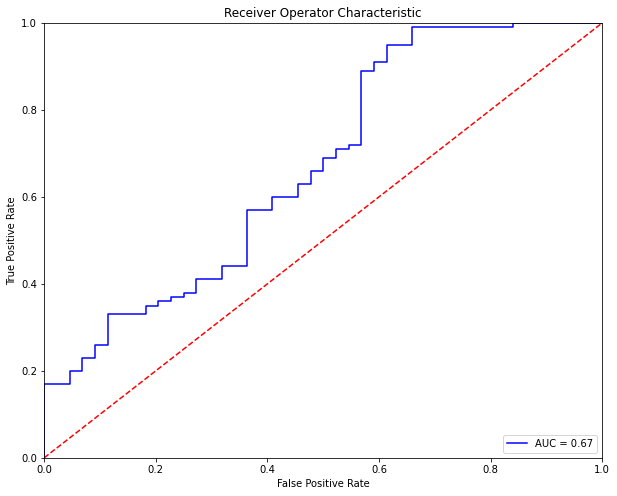

In [11]:
#Creating the ROC-AUC plot
preds = log_model.predict_proba(X_test)[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,8))
plt.title('Receiver Operator Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = {}'.format(round(roc_auc, 2)))
plt.legend(loc = 'lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Using only Significant Features

In [13]:
#Get the list of all the significant pairwise
significant_chi = []
for i in res_chi_ph[res_chi_ph['Hypothesis'] == 'Reject Null Hypothesis']['Pair']:
    significant_chi.append('{}_{}'.format(i.split('-')[0],i.split('-')[1]))
#Drop the data with duplicate information
for i in ['Married_No', 'Credit_History_0.0']:
    significant_chi.remove(i)
#Including the numerical data, as I have not analyze any of this feature
for i in loan.select_dtypes('number').columns:
    significant_chi.append(i)
print(significant_chi)
Out: ['Married_Yes', 'Credit_History_1.0','Property_Area_Semiurban',
 'ApplicantIncome','CoapplicantIncome', 'LoanAmount']

['Married_Yes', 'Credit_History_1.0', 'Property_Area_Semiurban', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']
